In [291]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm


In [55]:
disp_figs = True

In [338]:
# A layer of different Izhikevich neurons that that are very excitable and thus spontaneously generate spikes
# N is number of layer 1 neurons, M is number of layer 2 neurons
N = 21
M = 21 # these are inhibitory neurons?

# feed-forward with lateral recurrency in layer 2?

rs = {'a': 0.02, 'b': 0.20, 'c': -65.0, 'd': 8.00}
ib = {'a': 0.02, 'b': 0.20, 'c': -55.0, 'd': 4.00}
ch = {'a': 0.02, 'b': 0.20, 'c': -50.0, 'd': 2.00}
fs = {'a': 0.10, 'b': 0.20, 'c': -65.0, 'd': 2.00}
th = {'a': 0.02, 'b': 0.25, 'c': -65.0, 'd': 0.05}
res = {'a': 0.10, 'b': 0.25, 'c': -65.0, 'd': 2.00}
lts = {'a': 0.02, 'b': 0.25, 'c': -65.0, 'd': 2.00}
nrns={
    'rs':rs,
    'in':ib,
    'ch':ch,
    'fs':fs,
    'th':th,
    'res':res,
    'lts':lts,
}
nrn_types = np.array([3*[k] for k in nrns]).flatten()

a = [nrns[k]['a'] for k in nrn_types]
b = [nrns[k]['b'] for k in nrn_types]
c = [nrns[k]['c'] for k in nrn_types]
d = [nrns[k]['d'] for k in nrn_types]
paramsl1 = np.array([a,b,c,d])
paramsl2 = np.array([a,b,c,d])

T = 10000 # length in samples
dt = 0.1


coincident_psps = 2
psp_amp = 120/coincident_psps*np.ones((N))



S = {'weights':np.random.randint(5,10,(N,M))/N, # set of all synapses (should be a )
     'delays':np.random.randint(2,20,(N,M))  # fixed delays
    }

init_S = S.copy()

In [414]:
def run_l1(T,params,dt=0.1):
    N=params.shape[1]
    a,b,c,d = params
    
    V_0 = c
    u_0 = -14
    V_spike = 35

    V = np.zeros((T,N))
    u = np.zeros((T,N))
    V[0,...] = V_0*np.ones(N)
    u[0,...] = u_0*np.ones(N)
    spikes = np.zeros((T,N))
    stim = np.zeros(T)


    spikes = np.zeros_like(V)
    for t in tqdm (range(1, len(V[:,0]))):
        noise = np.random.randint(8,10,N)/10
        # if we still didnt reach spike potential
        for i in range(V.shape[1]):
            stim[t] = (1+np.sin(t*dt**2.5*noise[i]))
            if V[t-1,i] < V_spike:
                # ODE for membrane potential
                dV      = (0.04 * V[t-1,i] + 5) * V[t-1,i] + 140 - u[t-1,i]
                V[t,i]    = V[t-1,i] + (dV + 3*stim[t]) * dt # these cells have a low base input... lol
                # ODE for recovery variable
                du      = a[i] * (b[i] * V[t-1,i] - u[t-1,i])
                u[t,i]    = u[t-1,i] + dt * du
            # spike reached!
            else:
                V[t-1,i] = V_spike    # set to spike value
                V[t,i] = c[i]                # reset membrane voltage
                u[t,i] = u[t-1,i] + d[i]       # reset recovery
                spikes[t-1,i] = 1
                
    return V, spikes,stim

In [415]:
if disp_figs:
    V1, spikes,stim = run_l1(T,paramsl1)
    %matplotlib qt
    fig,ax = plt.subplot_mosaic('AB')
    ax['A'].plot(np.arange(0,int(T*dt),dt),V1,alpha=0.5)
    ax['B'].scatter(np.where(spikes==1)[0]*dt,np.where(spikes==1)[1],color='black')
    ax['B'].plot(np.arange(0,int(T*dt),dt),stim,alpha=0.5)

100%|███████████████████████████████████████████████████████████████████████████| 9999/9999 [00:00<00:00, 11287.55it/s]


In [416]:
def run_l2(I,S,params,dt=0.1,psp_amp=60):
    # I is a dense input matrix with the form ( T X N )
    
    T=I.shape[0]
    N=params.shape[1]
    a,b,c,d = params
    psp_amp=psp_amp*np.ones(N)
    
    V_0 = c
    u_0 = -14
    V_spike = 35

    V = np.zeros((T,N))
    u = np.zeros((T,N))
    V[0,...] = V_0*np.ones(N)
    u[0,...] = u_0*np.ones(N)
    spikes = np.zeros((T,N))
    stim = np.zeros(T)
    
    spikes = np.zeros_like(V)
    for t in tqdm(range(1, len(V[:,0]))):
        # if we still didnt reach spike potential
        for i in range(V.shape[1]):
            # calculate incoming psps
            PSC = sum(I[t,...,i])*psp_amp[i]       
            if V[t-1,i] < V_spike:
                # ODE for membrane potential
                dV      = (0.04 * V[t-1,i] + 5) * V[t-1,i] + 140 - u[t-1,i]
                V[t,i]    = V[t-1,i] + (dV +PSC) * dt # these cells have a low base input... lol
                # ODE for recovery variable
                du      = a[i] * (b[i] * V[t-1,i] - u[t-1,i])
                u[t,i]    = u[t-1,i] + dt * du
            # spike reached!
            else:
                V[t-1,i] = V_spike    # set to spike value
                V[t,i] = c[i]                # reset membrane voltage
                u[t,i] = u[t-1,i] + d[i]       # reset recovery
                spikes[t-1,i] = 1
    return V, spikes

In [417]:
delayed_I = np.zeros((T,N,M))
for i in range(M):
    for j in range(N):
        d = S['delays'][i][j]
        delayed_I[:,i,j] = np.concatenate((d*[0],spikes.T[i][:-d]))
        

In [418]:
x = [1,2,3,4,5]
2*[0],x[:-2]

([0, 0], [1, 2, 3])

In [419]:
if disp_figs:
    plt.figure()
    plt.scatter(np.where(spikes==1)[0]*dt,np.where(spikes==1)[1],alpha=0.9)
    plt.scatter(np.where(delayed_I[...,1]==1)[0]*dt,np.where(delayed_I[...,1]==1)[1],alpha=0.5)
    plt.show()

In [420]:
if disp_figs:
    V2, out = run_l2(delayed_I,S,paramsl2,dt=dt,psp_amp=psp_amp)
    plt.figure()
    plt.scatter(np.where(out==1)[0]*dt,np.where(out==1)[1],color='black', marker='.',alpha=0.9,s=100)
#     plt.scatter(np.where(spikes==1)[0]*dt,np.where(spikes==1)[1],marker='.',s=100)
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████| 9999/9999 [00:00<00:00, 10434.67it/s]


In [423]:
def run_l2_inh(I,S,params,dt=0.1,psp_amp=60):
    # I is a dense input matrix with the form ( T X N )
    
    T=I.shape[0]
    N=params.shape[1]
    a,b,c,d = params
    psp_amp=psp_amp*np.ones(N)
    
    V_0 = c
    u_0 = -14
    V_spike = 35

    V = np.zeros((T,N))
    u = np.zeros((T,N))
    V[0,...] = V_0*np.ones(N)
    u[0,...] = u_0*np.ones(N)
    spikes = np.zeros((T,N))
    stim = np.zeros(T)
    debug_depress = np.zeros((T,N))
    
    spikes = np.zeros_like(V)
    for t in tqdm(range(1, len(V[:,0]))):
        # if we still didnt reach spike potential
        for i in range(V.shape[1]):
            # calculate incoming psps
            if spikes[t-1,i-1] or spikes[t-1,(i+1)%N]:
                PSC = -20*psp_amp[i]
                debug_depress[t,i]=1
            else:
                PSC = sum(I[t-1,...,i])*psp_amp[i]       
            if V[t-1,i] < V_spike:
                # ODE for membrane potential
                dV      = (0.04 * V[t-1,i] + 5) * V[t-1,i] + 140 - u[t-1,i]
                V[t,i]    = V[t-1,i] + (dV +PSC) * dt # these cells have a low base input... lol
                # ODE for recovery variable
                du      = a[i] * (b[i] * V[t-1,i] - u[t-1,i])
                u[t,i]    = u[t-1,i] + dt * du
            # spike reached!
            else:
                V[t-1,i] = V_spike    # set to spike value
                V[t,i] = c[i]                # reset membrane voltage
                u[t,i] = u[t-1,i] + d[i]       # reset recovery
                spikes[t,i] = 1
    return V, spikes,debug_depress

In [424]:
V3, out3,debug_depress = run_l2_inh(delayed_I,S,paramsl2,dt=dt,psp_amp=psp_amp)

100%|████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:01<00:00, 9142.13it/s]


In [425]:
plt.figure()
plt.scatter(np.where(debug_depress==1)[0]*dt,np.where(debug_depress==1)[1],alpha=0.9)
plt.scatter(np.where(out3==1)[0]*dt,np.where(out3==1)[1],alpha=0.9)

In [426]:
plt.figure()
plt.plot(V3[:,0])
plt.show()

In [427]:
if disp_figs:
    fig,ax = plt.subplot_mosaic('AB')
    ax['A'].scatter(np.where(out3==1)[0]*dt,np.where(out3==1)[1],color='black', marker='.',alpha=0.9,s=100)
    ax['B'].scatter(np.where(out==1)[0]*dt,np.where(out==1)[1],color='black', marker='.',alpha=0.9,s=100)
    plt.show()

In [15]:
sigmoid = lambda x: 1/(1 + np.exp(-x))


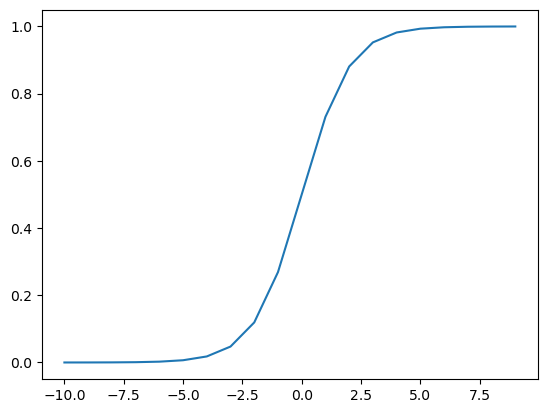

In [18]:
plt.figure()
plt.plot(np.arange(-10,10),sigmoid(np.arange(-10,10)))
plt.show()

In [13]:
np.random.randint(0,9,(N,M))

array([[2, 7, 5, 8, 3, 1, 0, 5, 4, 7, 3, 4, 7, 0, 4, 4, 7, 4, 2, 5],
       [6, 7, 7, 8, 5, 5, 0, 1, 0, 1, 8, 1, 5, 7, 6, 8, 2, 0, 7, 4],
       [3, 0, 3, 1, 7, 5, 3, 6, 8, 1, 1, 3, 3, 3, 5, 2, 0, 1, 2, 3],
       [4, 7, 5, 5, 6, 6, 2, 6, 4, 1, 7, 0, 3, 1, 2, 5, 1, 2, 3, 3],
       [3, 5, 6, 8, 1, 1, 0, 4, 4, 4, 5, 2, 7, 2, 2, 1, 1, 2, 0, 3],
       [8, 0, 3, 1, 5, 2, 4, 0, 5, 0, 3, 5, 7, 5, 5, 6, 8, 3, 6, 8],
       [2, 8, 5, 6, 7, 6, 8, 7, 1, 6, 0, 7, 8, 1, 8, 4, 4, 1, 4, 5],
       [5, 3, 7, 1, 8, 5, 4, 0, 5, 4, 4, 7, 1, 3, 2, 5, 8, 5, 3, 7],
       [7, 3, 3, 8, 0, 8, 3, 8, 7, 2, 0, 2, 4, 7, 3, 3, 2, 6, 8, 3],
       [7, 0, 8, 4, 8, 2, 7, 5, 1, 2, 5, 6, 6, 4, 2, 6, 6, 3, 4, 6],
       [3, 6, 2, 6, 3, 5, 3, 2, 7, 3, 7, 4, 0, 5, 5, 3, 4, 3, 5, 2],
       [7, 2, 8, 2, 3, 0, 3, 1, 4, 3, 2, 4, 8, 4, 5, 3, 5, 5, 1, 2],
       [0, 5, 5, 3, 6, 3, 6, 8, 6, 8, 3, 2, 2, 8, 7, 6, 2, 0, 7, 3],
       [5, 2, 6, 2, 7, 2, 1, 4, 5, 6, 8, 6, 2, 7, 5, 8, 2, 8, 6, 1],
       [1, 8, 8, 1, 5, 1, 2, 1, 6,